In [1]:
from st_utils import *
from H2TL import *

# some stuff to make this notebook work better with Scanpy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

---
### Read in Visium ST Anndata
This uses standard `scanpy` functions

In [2]:
a1 = sc.read("data/V1_Breast_Cancer_Block_A_Section_1_raw.h5ad"); a1

AnnData object with n_obs × n_vars = 4992 × 25062
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

In [3]:
a2 = sc.read("data/V1_Breast_Cancer_Block_A_Section_2_raw.h5ad"); a2

AnnData object with n_obs × n_vars = 4992 × 25149
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial'
    obsm: 'spatial'

---
### Map ST data to histology pixels and trim images
This uses functions from `st_utils.py`

In [4]:
a1 = map_pixels(a1, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 3798 spots x 25062 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Breast_Cancer_Block_A_Section_1']['images']['hires_trim']
Plotting pita as RGB image
Done!


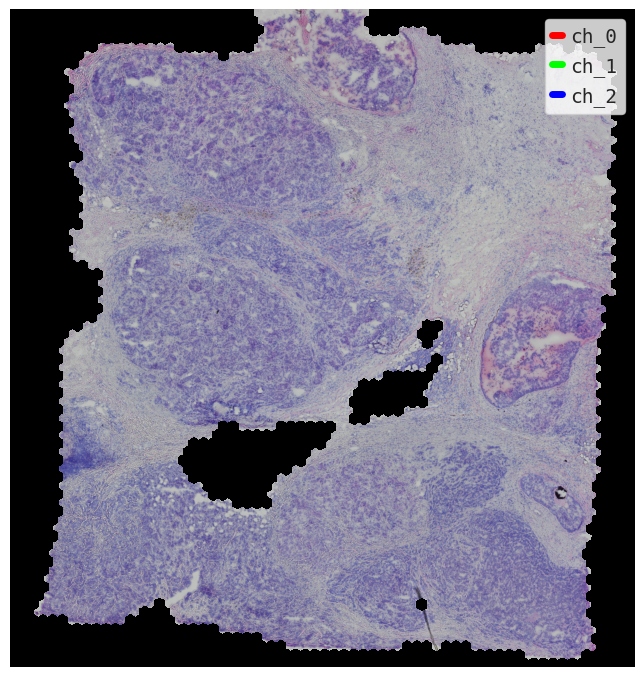

In [5]:
a1_image = trim_image(a1)

In [6]:
a2 = map_pixels(a2, filter_label="in_tissue")

Creating pixel grid and mapping to nearest barcode coordinates
Saving barcode mapping to adata.uns['pixel_map_df'] and adding metadata
Filtering barcodes using labels in self.adata.obs['in_tissue']
New size: 3987 spots x 25149 genes
Done!


Cropping image to pixel dimensions and adding values to adata.uns['pixel_map_df']
Cropping Visium spot coordinates and saving to adata.obsm['spatial_trim']
Saving cropped and trimmed image to adata.uns['spatial']['V1_Breast_Cancer_Block_A_Section_2']['images']['hires_trim']
Plotting pita as RGB image
Done!


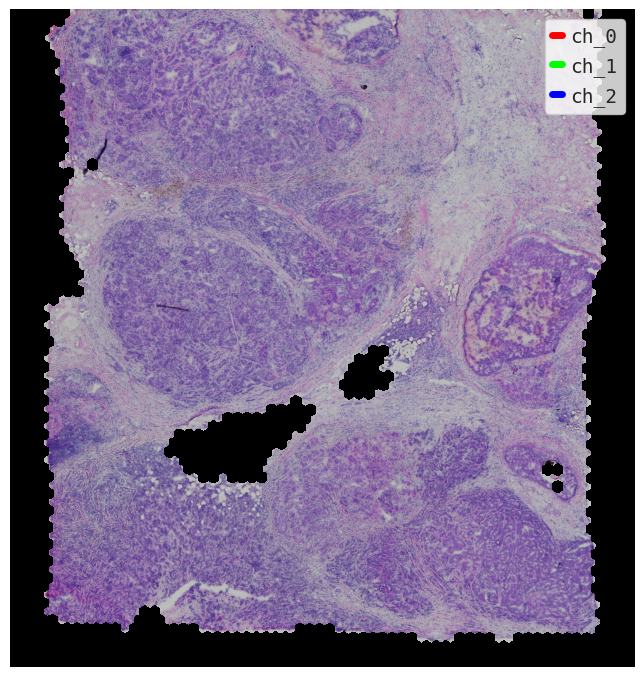

In [7]:
a2_image = trim_image(a2)

---
### Perform joint PCA to get a low-dimensional space for clustering
Again, standard `scanpy`/`anndata` functions here

In [8]:
a_comb = a1.concatenate([a2], fill_value=0, join="outer"); a_comb

AnnData object with n_obs × n_vars = 7785 × 26384
    obs: 'in_tissue', 'array_row', 'array_col', 'batch'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1'
    obsm: 'spatial', 'spatial_trim', 'image_means'

In [9]:
sc.pp.normalize_total(a_comb)
sc.pp.log1p(a_comb)
sc.pp.scale(a_comb)
sc.pp.pca(a_comb, n_comps=50)

... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical


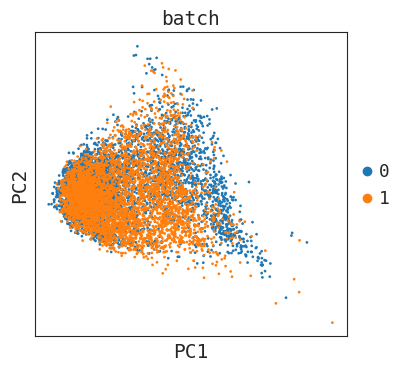

/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/cody/.virtualenvs/sc/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


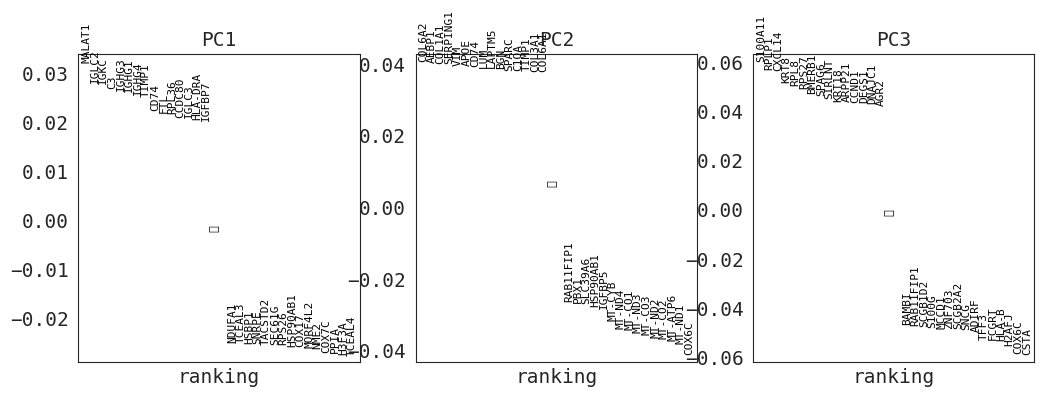

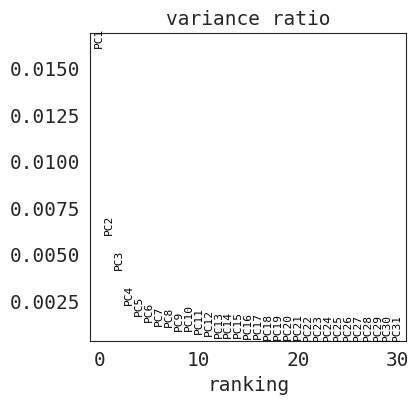

In [10]:
sc.pl.pca_overview(a_comb, color="batch")

In [11]:
# add PCA coordinates to original anndata objects
a1.obsm["X_pca"] = a_comb[a_comb.obs.batch=="0",:].obsm["X_pca"]
a2.obsm["X_pca"] = a_comb[a_comb.obs.batch=="1",:].obsm["X_pca"]

---
### Create `st_labeler` object and define macro clusters based on transcriptomics and histology
This comes from `H2TL.py`

In [12]:
tl = st_labeler([a1, a2])

Initiating ST labeler with 2 anndata objects


#### Since we have brightfield histology for both sections, we can set `histo=True` to include imaging features (R, G, B channels) in the clustering model

In [13]:
%time tl.prep_cluster_data(use_rep="X_pca", features=[0,1,2,3,4,5,6], blur_pix=2, histo=True)

Adding mean RGB histology features for adata #0
Blurring training features for adata #0
Adding mean RGB histology features for adata #1
Blurring training features for adata #1
Collected clustering data of shape: (7785, 10)
CPU times: user 1min 39s, sys: 227 ms, total: 1min 40s
Wall time: 1min 44s


#### We'll try labeling the tissue with 5 regional cluster IDs

In [24]:
%time tl.label_tissue_regions(plot_out=True, k=6)

Overriding optimal k value with k=6.
Performing k-means clustering with 6 target clusters
Adding tissue_ID label to anndata objects
CPU times: user 898 ms, sys: 116 ms, total: 1.01 s
Wall time: 3.75 s


#### Now show the features used for clustering after spatial blurring along with the final `tissue_ID` in each section

Assembling pita with 11 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!
Assembling pita with 11 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!


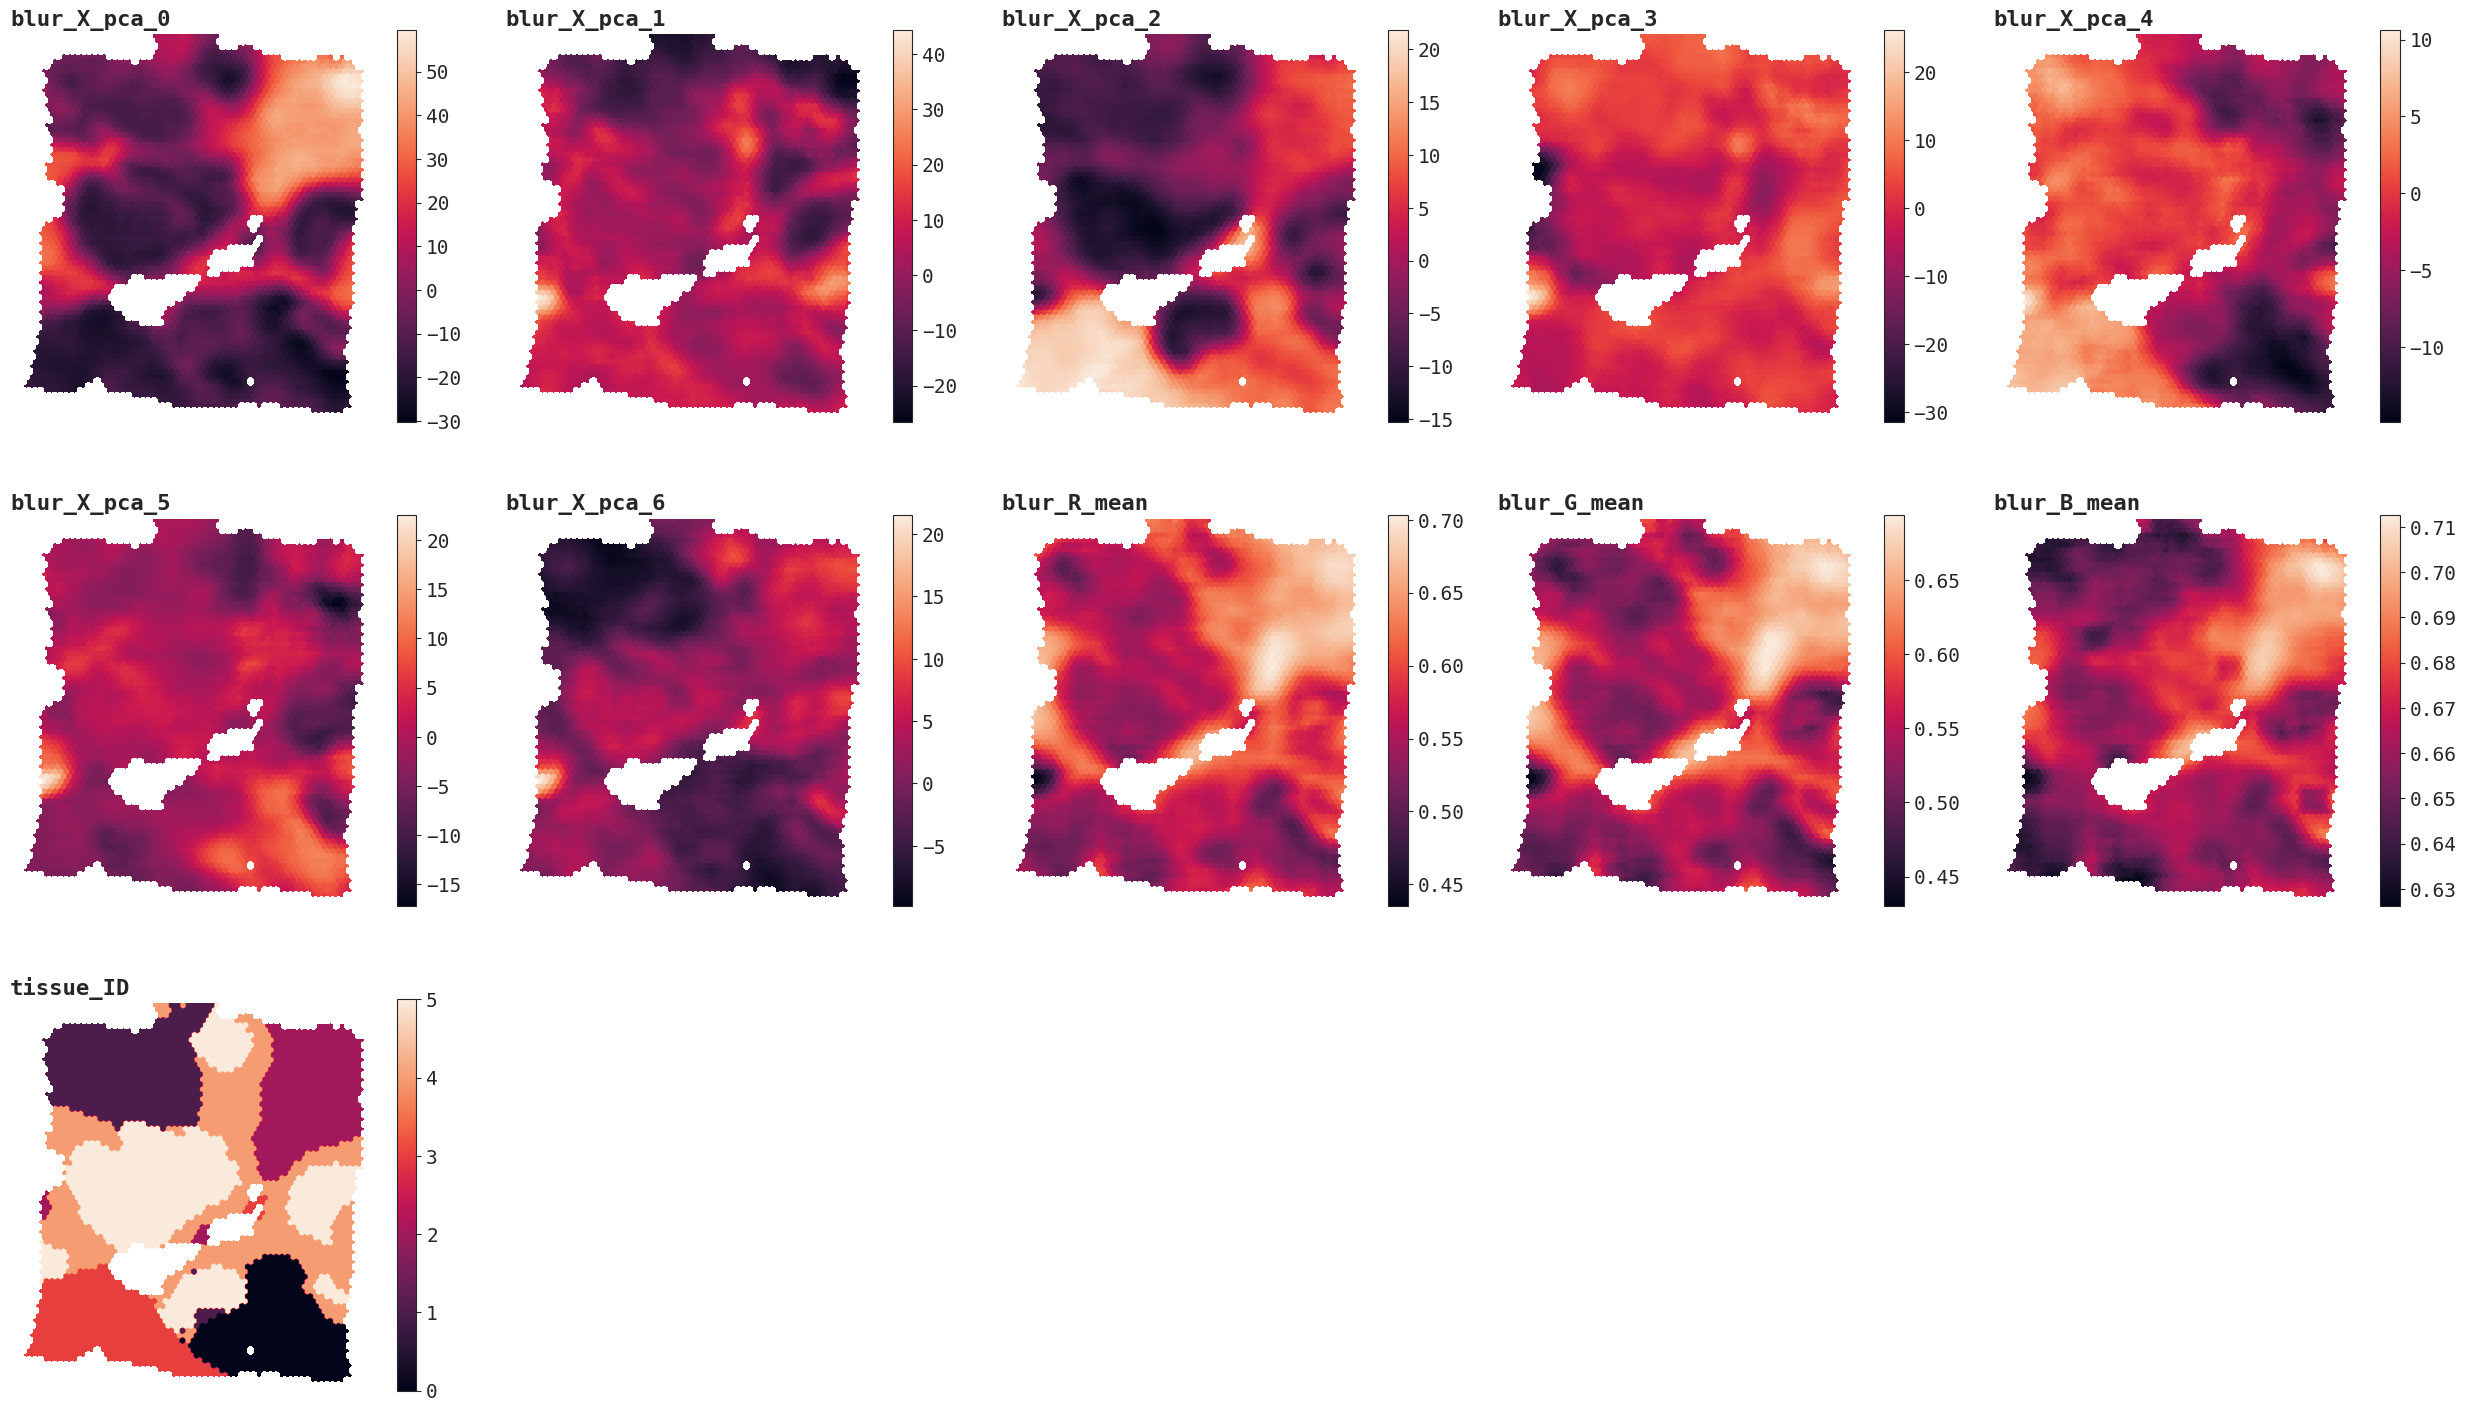

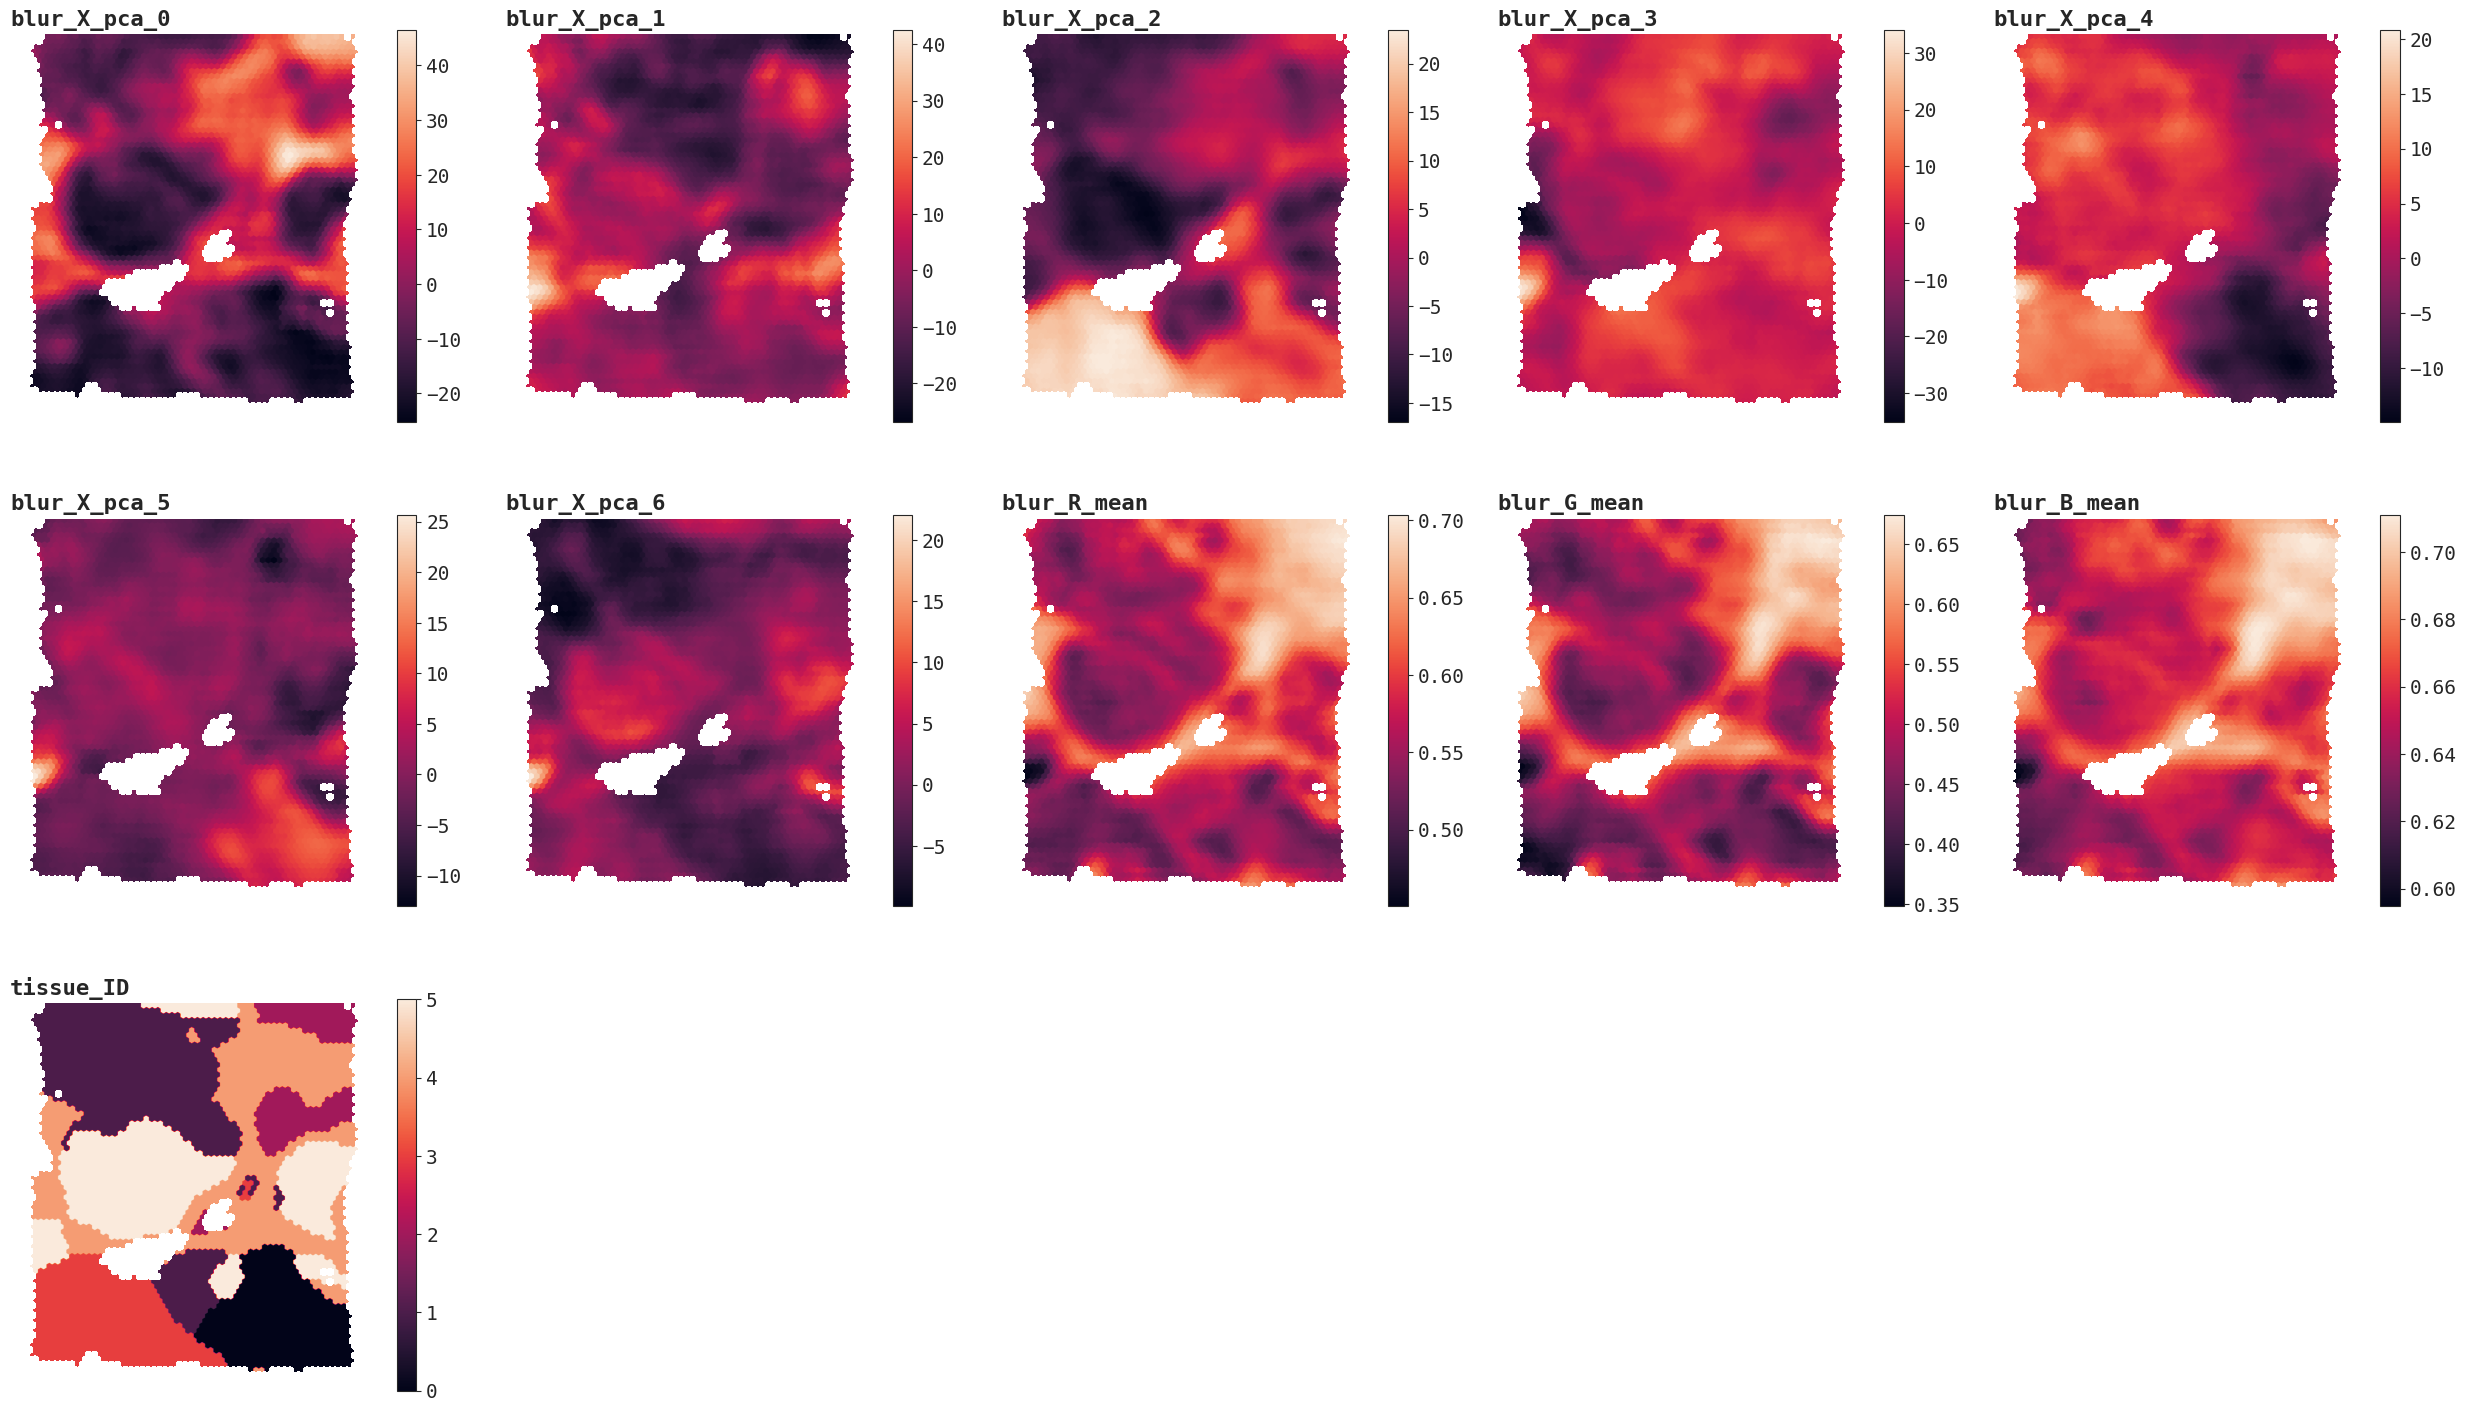

In [25]:
for i in range(len(tl.adatas)):
    n = list(tl.adatas[i].obs.columns[tl.adatas[i].obs.columns.str.startswith("blur_")]) + ["tissue_ID"]
    p = assemble_pita(tl.adatas[i], use_rep=".obs", features=n, ncols=5, label=n)

Assembling pita with 1 features from adata.obs
Casting barcodes to pixel dimensions and saving to adata.uns['pixel_map']
Done!


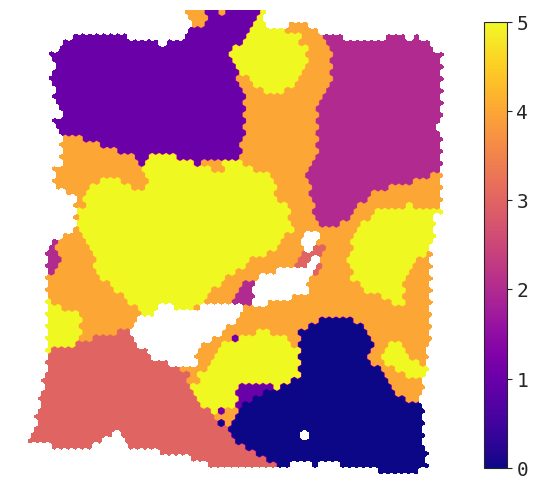

In [28]:
p = assemble_pita(tl.adatas[0], use_rep=".obs", features="tissue_ID", figsize=(6,6), cmap="plasma", save_to="example_ID.png")

In [20]:
import matplotlib.pyplot as plt

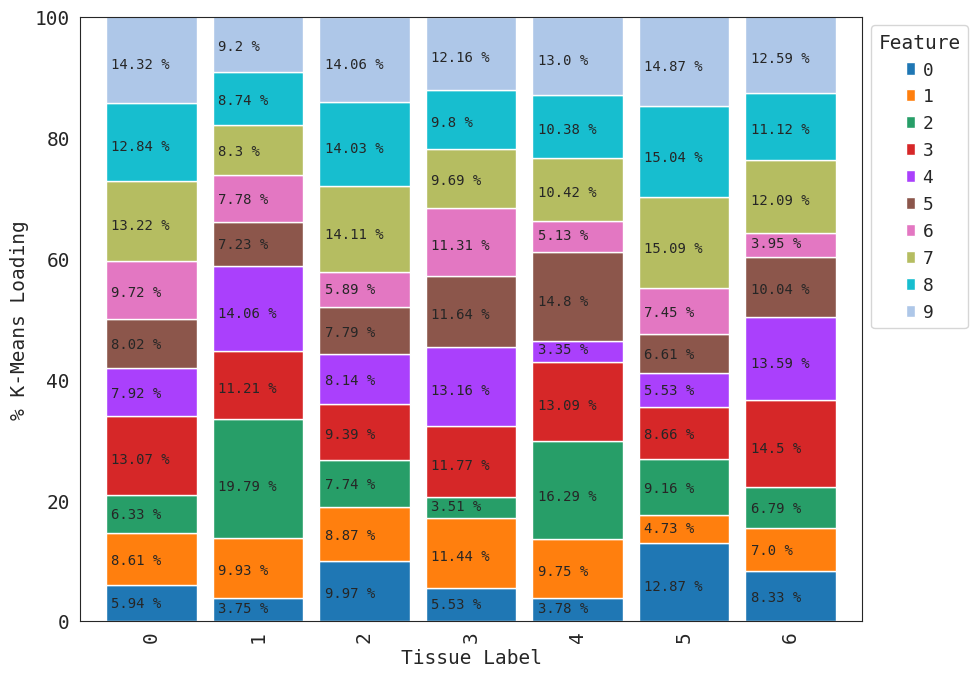

In [23]:
centers = pd.DataFrame(tl.kmeans.cluster_centers_)#, columns=["PC" + str(x) for x in tl.features])
totals = centers.sum(axis=1)
centers_prop = centers.div(totals, axis=0).multiply(100)

fig, ax = plt.subplots(1,1,figsize=(10,7))
centers_prop.plot.bar(stacked=True, ax=ax, width=0.85)
for p in ax.patches:
    ax.annotate('{} %'.format(str(np.round(p.get_height(), 2))), (p.get_x()+0.05, p.get_y()+(p.get_height()*0.4)), fontsize=10)
plt.ylim([0,100])
plt.xlabel("Tissue Label")
plt.ylabel("% K-Means Loading")
plt.legend(bbox_to_anchor=(1,1), loc="upper left", title="Feature")
plt.tight_layout()
plt.show()